In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

import os
from pprint import pprint

import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from lightning_module import SegmentModule

In [3]:
# DEVICE = 'cuda:0' if torch.cuda.is_available else 'cpu'
DEVICE = 'cpu'
DATA_PATH = '../data'

In [31]:
# Загружаем модель

checkpoint_name = '..\\experiments\\unet_resnet34_d_f_320\\epoch_epoch=27-val_IoU=0.889.ckpt'
module = SegmentModule.load_from_checkpoint(checkpoint_name, map_location=torch.device('cpu'))

_ = module.eval()
_ = module.to(DEVICE)

In [32]:
# Загружаем данные
df = pd.read_csv('..\\data\\df_test.csv')
names = list(df.columns[1:])
names
df.head(2)

['x_from', 'y_from', 'width', 'height']

,filename,x_from,y_from,width,height
0,images/fb1ec415-58e8-4374-97a9-d0e37fd5a225--r...,48,617,496,338
1,images/e97ed90b-6c78-43ee-9d63-e145f65c1eb7--r...,322,619,458,219


In [33]:
# препроцессинг данных 
from augmentations import get_transforms
test_transforms = get_transforms(width=320, height=320, encoder = 'resnet34', augmentations=False)

In [42]:
def mask_postprocesing(prob_mask, threshold):
    mask = (prob_mask > threshold).astype(np.uint8)
    mask = mask.transpose(1, 2, 0)
    num_labels, labels_im = cv2.connectedComponents(mask)
    max_size = 0
    max_label = 0
    for label in range(1, num_labels):
        component = (labels_im == label).astype(np.uint8)
        size = cv2.countNonZero(component)
        if size > max_size:
            max_size = size
            max_label = label

    largest_component_mask = (labels_im == max_label).astype(np.uint8)

    largest_component_mask = (largest_component_mask > 0).astype(np.uint8)
    return largest_component_mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


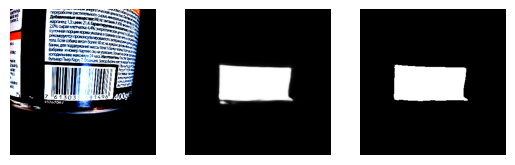

In [45]:
idx = 10
image_name = os.path.normpath(os.path.join(DATA_PATH, df["filename"][idx]))
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
procecces_image = test_transforms(image=image)['image']
procecces_image = procecces_image.float()
with torch.no_grad():
    prob_mask = torch.sigmoid(module(procecces_image[None].to(DEVICE)))[0].cpu().numpy()
    
mask = mask_postprocesing(prob_mask, 0.5)
procecces_image = procecces_image.permute(1, 2, 0)
plt.subplot(1,3,1)
plt.axis("off")
plt.imshow(procecces_image.squeeze())
plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(prob_mask.squeeze(), cmap='gray')
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(mask.squeeze(), cmap='gray')
plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


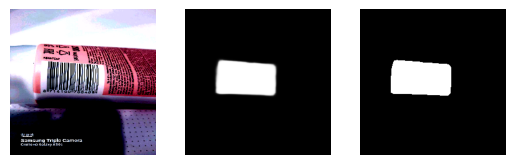

In [21]:
import typing as tp
import os
import cv2
import numpy as np
import torch
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import argparse 
import segmentation_models_pytorch as smp
import onnxruntime as ort

MODEL_THRESHOLD = 0.4
TARGET_IMAGE_SIZE = (256, 256)
MODEL_ENCODER = 'resnet34'
PRETRAINED_WEIGHTS = 'imagenet'

def mask_postprocesing(prob_mask, threshold):
    mask = (prob_mask > threshold).astype(np.uint8)
    mask = mask.transpose(1, 2, 0)
    num_labels, labels_im = cv2.connectedComponents(mask)
    max_size = 0
    max_label = 0
    for label in range(1, num_labels):
        component = (labels_im == label).astype(np.uint8)
        size = cv2.countNonZero(component)
        if size > max_size:
            max_size = size
            max_label = label

    largest_component_mask = (labels_im == max_label).astype(np.uint8)

    largest_component_mask = (largest_component_mask > 0).astype(np.uint8)
    return largest_component_mask


def preprocess_image(image: np.ndarray, target_image_size: tp.Tuple[int, int]) -> torch.Tensor:

    image = image.astype(np.float32)
    
    processing_smp = smp.encoders.get_preprocessing_fn(MODEL_ENCODER, pretrained = PRETRAINED_WEIGHTS)

    preprocess = albu.Compose(
            [
                albu.Resize(height=target_image_size, width=target_image_size),
                albu.Lambda(image=processing_smp),
                ToTensorV2(),
            ]
    )
    image_array = preprocess(image=image)['image'] 
    image_array = image_array.float().numpy() 
    
    return image_array

def run_inference(session, input_data):
    input_name = session.get_inputs()[0].name

    outputs = session.run(None, {input_name: input_data})
    return outputs

image_path = "../data/images/0.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = preprocess_image(img, 256)

ONNX_MODEL_NAME = '../model_weights/onnx_model.onnx'

ort_session = ort.InferenceSession(
    ONNX_MODEL_NAME,
    providers=['CPUExecutionProvider',],
)

# Run inference
output = run_inference(ort_session, img[None])
prob_mask = torch.sigmoid(torch.tensor(output[0]))[0].numpy()
mask = mask_postprocesing(prob_mask, MODEL_THRESHOLD)

procecces_image = img.transpose(1, 2, 0)
plt.subplot(1,3,1)
plt.axis("off")
plt.imshow(procecces_image.squeeze())
plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(prob_mask.squeeze(), cmap='gray')
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(mask.squeeze(), cmap='gray')
plt.show();